In [12]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from IPython.display import clear_output

from env import TCLs
from lib.admm import *
from utils.plot import plotDensity

import cvxpy as cp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Use Case 2: Minimize Ramping
### Load the Duck Curve

In [2]:
filePath = "data/"

generation = pd.read_csv(filePath + "CAISO-renewables-20200331.csv")
generation = generation.set_index('Renewables 03/31/2020')
generation = pd.DataFrame(generation.values.T, index = generation.columns, columns= generation.index)

demand = pd.read_csv(filePath + "CAISO-demand-20200331.csv")
demand = demand.set_index('Demand 03/31/2020')
demand = pd.DataFrame(demand.values.T, index = demand.columns, columns= demand.index)

/Users/chenbq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


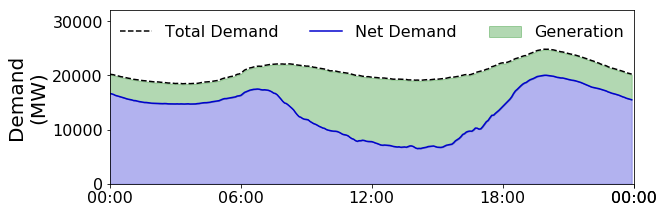

In [3]:
fig, ax = plt.subplots(figsize = (8, 3), sharex = 'all')
fig.tight_layout()
start_time = pd.datetime(year = 2020, month = 3, day =31)
end_time = start_time + pd.Timedelta(days = 1)
datelist = pd.date_range(start_time, end_time, freq = '5T').tolist()
datelist = datelist
t = pd.Series(np.arange(289), index = datelist).index.to_pydatetime()


p = ax.fill_between(t[:288], demand["Demand (5 min. avg.)"][:288].values-generation.sum(axis = 1).values, 
                demand["Demand (5 min. avg.)"][:288].values, alpha = 0.3,
                color = 'green', label = "Generation")

p = ax.fill_between(t[:288], demand["Demand (5 min. avg.)"][:288].values-generation.sum(axis = 1).values, 
                np.zeros(288), alpha = 0.3,
                color = 'mediumblue')#, label = "Renewable Generation")


l1, = ax.plot(t[:288], demand["Demand (5 min. avg.)"][:288].values+100, 'k--', label = "Total Demand")
l2, = ax.plot(t[:288], demand["Demand (5 min. avg.)"][:288].values-generation.sum(axis = 1).values, 
        'mediumblue', label = "Net Demand")

ax.legend(fontsize = 16, loc = 'upper center', frameon = False, ncol = 3)
ax.set_xlim(start_time, end_time)
ax.set_ylim(0, 32000)
ax.set_ylabel("Demand\n(MW)", fontsize = 20)

ax.set_xticks(t[::72].tolist()+[end_time])
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
ax.tick_params(axis='both', which='major', labelsize=16)

In [4]:
n_agent = 1000

Ta = 32
Tsp = 22.5
Delta = 1
eta = 2.5
R = 2
P0 = (Ta-Tsp)/(eta*R) # Baseline energy consumption from On-Off control

# Resample to 15 min
duck_curve = demand["Demand (5 min. avg.)"].iloc[:288]-generation.sum(axis = 1)
duck_15 = []
for i in range(len(duck_curve)//3):
    duck_15.append(np.mean(duck_curve.values[i*3:(i+1)*3]))  
duck_15 = np.array(duck_15)

## Scale such that TCL accounts for 20% of total demand
k = np.mean(demand["Demand (5 min. avg.)"].iloc[:288])/(P0*n_agent*5)

non_hvac_demand = (duck_15/k-P0*n_agent)#.clip(0, None)

### Run Experiment

In [5]:
def g_ramping(v_agg, variable_list):
    ## variable_list = [net demend]
    return cp.tv(v_agg+variable_list[0])

In [6]:
T = 96 # Planning horizon
dt = 1/4 # Control timestep (Unit: Hour)
step_per_day = int(24/dt) 
m = 15 # Ratio between control timestep vs. simulation timestep

rho = 10 
eps = 10

env = TCLs.TCL_Cluster(n_agent, Delta =1) 
x_init, u_init, done = env.reset()#x_init = x_rbc[-1], u_init = p_rbc[-1])

print("u_init: ", np.sum(u_init))

param_list = []
for agent in env.TCL_list:
    param_list.append(agent.getParameters())
controllers = ControllerGroup(T, dt, param_list) ## TCL-level Controllers
aggregator = Aggregator(T, g_ramping, [(T)], n_agent, rho) ## Load Aggregator

controllers.updateState(x_init)#, u_prev)

x_list = [x_init]
u_list = [] # The continuous solution
p_list = [] # The On-Off actuation
iter_list = [] # Number of iterations

cur_idx = 0
while cur_idx < step_per_day:
    # Solve the coordination problem
    u_solution, n_iter = ADMM(controllers, aggregator, [non_hvac_demand], eps, eps)#, v_init=np.mean(u_prev, axis =0)) # N x T
    iter_list.append(n_iter)
    
    for u in u_solution.T:
        u_list.append(u)
        tmp = []
        for _ in range(m):
            # Track the agreed upon power profile with PWM
            x, r, p, _ = env.step(u, dt = dt/m, normalized = False, continuous = True)
            tmp.append(p)
            x_list.append(x)
            p_list.append(p)
        #print("Target = {}, Actual = {}".format(target, np.mean(tmp)*n_agent))
        
        controllers.updateState(x)
        cur_idx+=1
        #print("T = {}, Num. Of Iter. = {}".format(cur_idx, n_iter))

u_init:  1993.7791751059183


### Save Results

In [7]:
U_list = np.array(u_list)
P_list = np.array(p_list)

tmp = np.sum(P_list, axis =1)
P_avg = []
for i in range(step_per_day):
    P_avg.append(np.mean(tmp[m*i : m*(i+1)]))

result_dict = {"param_list":param_list, 
               "x_init":x_init, 
               "u_init":u_init, 
               "x_list":x_list, 
               "u_list":u_list,
               "p_list":p_list,
               "p_avg":P_avg,
               "m":m, 
               "non_hvac_demand":non_hvac_demand}

with open('results/ramping_result', 'wb') as file:
    pickle.dump(result_dict, file)

### Plot Results

In [8]:
ramping_dict = pickle.load(open('results/ramping_result', 'rb'))

In [9]:
start_time = pd.datetime(year = 2020, month = 3, day =31)
end_time = start_time + pd.Timedelta(days = 1)
datelist = pd.date_range(start_time, end_time, freq = '15T').tolist()
datelist = datelist
t_15min = pd.Series(np.arange(97), index = datelist).index.to_pydatetime()
t_15min = t_15min[:-1]

/Users/chenbq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


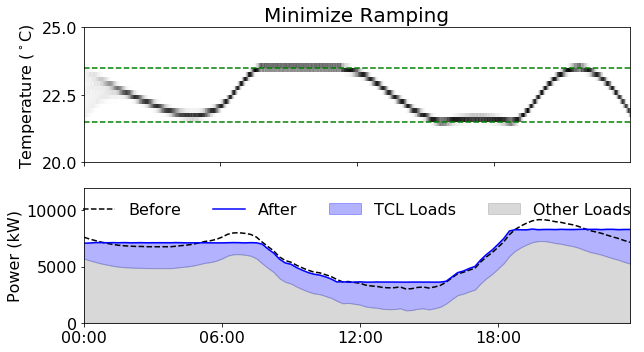

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(9,5))

myFmt = mdates.DateFormatter('%H:%M')

bins = np.arange(Tsp-1.5*Delta, Tsp+1.5*Delta+1e-3, Delta/6) 
deadband = [Tsp-Delta, Tsp+Delta]

## Use Case 2: 
plotDensity(ramping_dict['x_list'], axes[0], bins, deadband)
axes[0].set_title("Minimize Ramping", fontsize = 20)
axes[0].set_ylabel("Temperature ($^\circ$C)", fontsize = 16)
axes[0].tick_params(axis='x', which='both', labelbottom=False)
axes[0].tick_params(axis='y', which='major', labelsize=16)
axes[0].set_xticks([0, 6, 12, 18])
axes[0].set_yticks([20, 22.5, 25])

axes[1].plot(t_15min, P0*n_agent + np.array(ramping_dict['non_hvac_demand']), 'k--', label = "Before")
axes[1].plot(t_15min, np.array(ramping_dict['p_avg'])+np.array(ramping_dict['non_hvac_demand']), 'b',
               label = "After")

axes[1].fill_between(t_15min, np.array(ramping_dict['non_hvac_demand']), 
                        np.array(ramping_dict['p_avg'])+np.array(ramping_dict['non_hvac_demand']), 
                        color = 'b', alpha = 0.3, label = "TCL Loads")
axes[1].fill_between(t_15min, np.array(ramping_dict['non_hvac_demand']), color = 'grey', alpha = 0.3, 
                        label = "Other Loads")


axes[1].set_ylim(0, 12000)
#axes[1, 1].set_yticks([0, 1e4, 2e4])
axes[1].set_xlim(start_time, t_15min[-1])
axes[1].set_xticks(t_15min[::6*4].tolist())#+[end_time])
axes[1].xaxis.set_major_formatter(myFmt)
axes[1].set_ylabel("Power (kW)", fontsize = 16)
axes[1].tick_params(axis='both', which='major', labelsize=16)
axes[1].legend(fontsize = 16, loc = 'upper center', frameon = False, ncol = 4)

fig.tight_layout()